In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch 
from scipy.stats import pearsonr

from transformers import AutoTokenizer
from transformers import GPT2LMHeadModel

from sklearn.preprocessing import StandardScaler

# Gender Bias subspace through SVD?

There are several kinds of bias (stereotypes): racial, age-related, religion-related, gender-related.

Here we will try to analyse gender-related bias. In interest of time, we picked a bias that would be 'binary' (male and female). 
We ackowledge that gender is in fact not binary, but in interest of time and of our dataset, we analyse gender-related bias as binary.


## Data

We choose a set of words from https://github.com/chadaeun/weat_replication/blob/master/weat/Careers_Female_Male

This set of words, this dataset, has been used already in the the paper "Semantics derived automatically from language corpora contain human-like biases" by Caliskan, Bryson and Narayanan (2017) - given this, we find it interesting to explore this set of words further.


We create a matrix with these words (meaning, their tokenized word vectors) as rows, and the columns will be the latent spaces (768) from out GPT2 model.


Additionally, we scale each latent space (each column) to ensure that they all span equally.


## WEAT 6: science and arts target words along with male and female attributes - to do

Male names: John, Paul, Mike, Kevin, Steve, Greg, Jeff, Bill

Female names: Amy, Joan, Lisa, Sarah, Diana, Kate, Ann, Donna

Career words : executive, management, professional, corporation, salary, office, business, career
Family words : home, parents, children, family, cousins, marriage, wedding, relatives

## WEAT 7: science and arts target words along with male and female attributes - to do


Math words : math, algebra, geometry, calculus, equations, computation, numbers, addition
Arts Words : poetry, art, dance, literature, novel, symphony, drama, sculpture

Male attributes: male, man, boy, brother, he, him, his, son

Female attributes: female, woman, girl, sister, she, her, hers, daughter

## WEAT 8: science and arts target words along with male and female attributes - to do

Science words : science, technology, physics, chemistry, Einstein, NASA, experiment, astronomy
Arts words : poetry, art, Shakespeare, dance, literature, novel, symphony, drama

Male attributes: brother, father, uncle, grandfather, son, he, his, him

Female attributes: sister, mother, aunt, grandmother, daughter, she, hers, her

## WEFAT 1: occupations - in this notebook

Careers : technician, accountant, supervisor, engineer, worker, educator, clerk, counselor, inspector, mechanic, manager, therapist, administrator, salesperson, receptionist, librarian, advisor, pharmacist, janitor, psychologist, physician, carpenter, nurse, investigator, bartender, specialist, electrician, officer, pathologist, teacher, lawyer, planner, practitioner, plumber, instructor, surgeon, veterinarian, paramedic, examiner, chemist, machinist, appraiser, nutritionist, architect, hairdresser, baker, programmer, paralegal, hygienist, scientist

Female attributes: female, woman, girl, sister, she, her, hers, daughter

Male attributes: male, man, boy, brother, he, him, his, son

In [2]:
ws = ' technician, accountant, supervisor, engineer, worker, educator, clerk, counselor, inspector, mechanic, manager, therapist, administrator, salesperson, receptionist, librarian, advisor, pharmacist, janitor, psychologist, physician, carpenter, nurse, investigator, bartender, specialist, electrician, officer, pathologist, teacher, lawyer, planner, practitioner, plumber, instructor, surgeon, veterinarian, paramedic, examiner, chemist, machinist, appraiser, nutritionist, architect, hairdresser, baker, programmer, paralegal, hygienist, scientist, female, woman, girl, sister, she, her, hers, daughter, male, man, boy, brother, he, him, his, son'
ws = ws.strip().split(', ')
ws = [' ' + w for w in ws]
len(ws), ws[:5]

(66, [' technician', ' accountant', ' supervisor', ' engineer', ' worker'])

In [3]:
# ws[:50]
ws[50:58], ws[59:]

([' female',
  ' woman',
  ' girl',
  ' sister',
  ' she',
  ' her',
  ' hers',
  ' daughter'],
 [' man', ' boy', ' brother', ' he', ' him', ' his', ' son'])

In [4]:
model = GPT2LMHeadModel.from_pretrained('model_unique_rev_best/')
tok = AutoTokenizer.from_pretrained('gpt2')
tok.add_special_tokens({'pad_token': '<|endoftext|>'})

0

In [5]:
def get_word_vec(text):
    model_inp = tok(text, return_tensors='pt')
    outputs = model(**model_inp, output_hidden_states=True)
    hidden_states = outputs.hidden_states
    final_rep = hidden_states[-1]  # (1, N tokens, 768)
    final_rep = final_rep.mean(axis=1) # this makes it work also for special cases 
    final_rep = final_rep.squeeze()
    return final_rep

In [6]:
get_word_vec(ws[0]).shape

torch.Size([768])

In [7]:
dat = torch.zeros((len(ws), 768))
dat    

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [8]:
for ix, w in enumerate(ws):
    vec = get_word_vec(w)
    dat[ix, :] = vec
    
dat = dat.detach().numpy()
dat

array([[ 0.24856812, -1.0440538 , -0.38530695, ...,  0.03990982,
        -0.10753424,  0.00730459],
       [ 0.24470082, -1.0627973 , -0.32391465, ...,  0.02515118,
        -0.11964516,  0.01268686],
       [ 0.28352463, -0.9936409 , -0.33112872, ...,  0.02041074,
        -0.08235381,  0.01357216],
       ...,
       [ 0.16942759, -1.0756208 , -0.3418127 , ...,  0.03772319,
        -0.12411934, -0.00527881],
       [ 0.17104769, -1.0647882 , -0.38084367, ...,  0.02220581,
        -0.11339206, -0.03194879],
       [ 0.2556951 , -1.0188776 , -0.28324574, ...,  0.05187357,
        -0.12833916, -0.04818548]], dtype=float32)

In [9]:
dat.shape

(66, 768)

In [10]:
scaler = StandardScaler() #this scales the columns
scaled_dat = scaler.fit_transform(dat)
scaled_dat

array([[ 0.15342568, -0.54872143,  0.28647512, ..., -0.05758736,
        -0.19219445,  0.10803889],
       [ 0.11968773, -0.6133966 ,  0.5322287 , ..., -0.28732455,
        -0.34637487,  0.14668944],
       [ 0.4583831 , -0.37476996,  0.50335073, ..., -0.36111563,
         0.12837   ,  0.1530469 ],
       ...,
       [-0.53698903, -0.6576444 ,  0.4605827 , ..., -0.09162512,
        -0.40333423,  0.0176763 ],
       [-0.52285546, -0.6202663 ,  0.30434167, ..., -0.33317298,
        -0.26676846, -0.17384331],
       [ 0.21560086, -0.46185017,  0.6950264 , ...,  0.12864365,
        -0.45705542, -0.29044047]], dtype=float32)

## Bias subspace through SVD

Previous literature has explored the hypothesis of bias being in a linear subspace("Exploring the Linear Subspace Hypothesis in Gender Bias Mitigation", Vargas, Cotterell 2020, "Black is to Criminal as Cucasian is to Police: Detecting and Removing Multiclass Bias in Word Embeddings" Manzini, Lim, Tsvetkov, Black, 2019). In this paper, we try to explore whether in our dataset there gender bias is instrinsic of any specific mode given a singular value decomposition.


First, we try to explore whether there are some careers and words that get clustered around gendered words. To do this, we plot the first 2 principal componenets to explore whether some clusters and 'key' words/careers arise.

### Quick Dimensionality Redux + Plotting

In [11]:
from sklearn.decomposition import PCA

In [12]:
scaled_dat.shape

(66, 768)

In [13]:
pca = PCA(n_components = 2)

red_dat = pca.fit_transform(scaled_dat)
red_dat.shape

(66, 2)

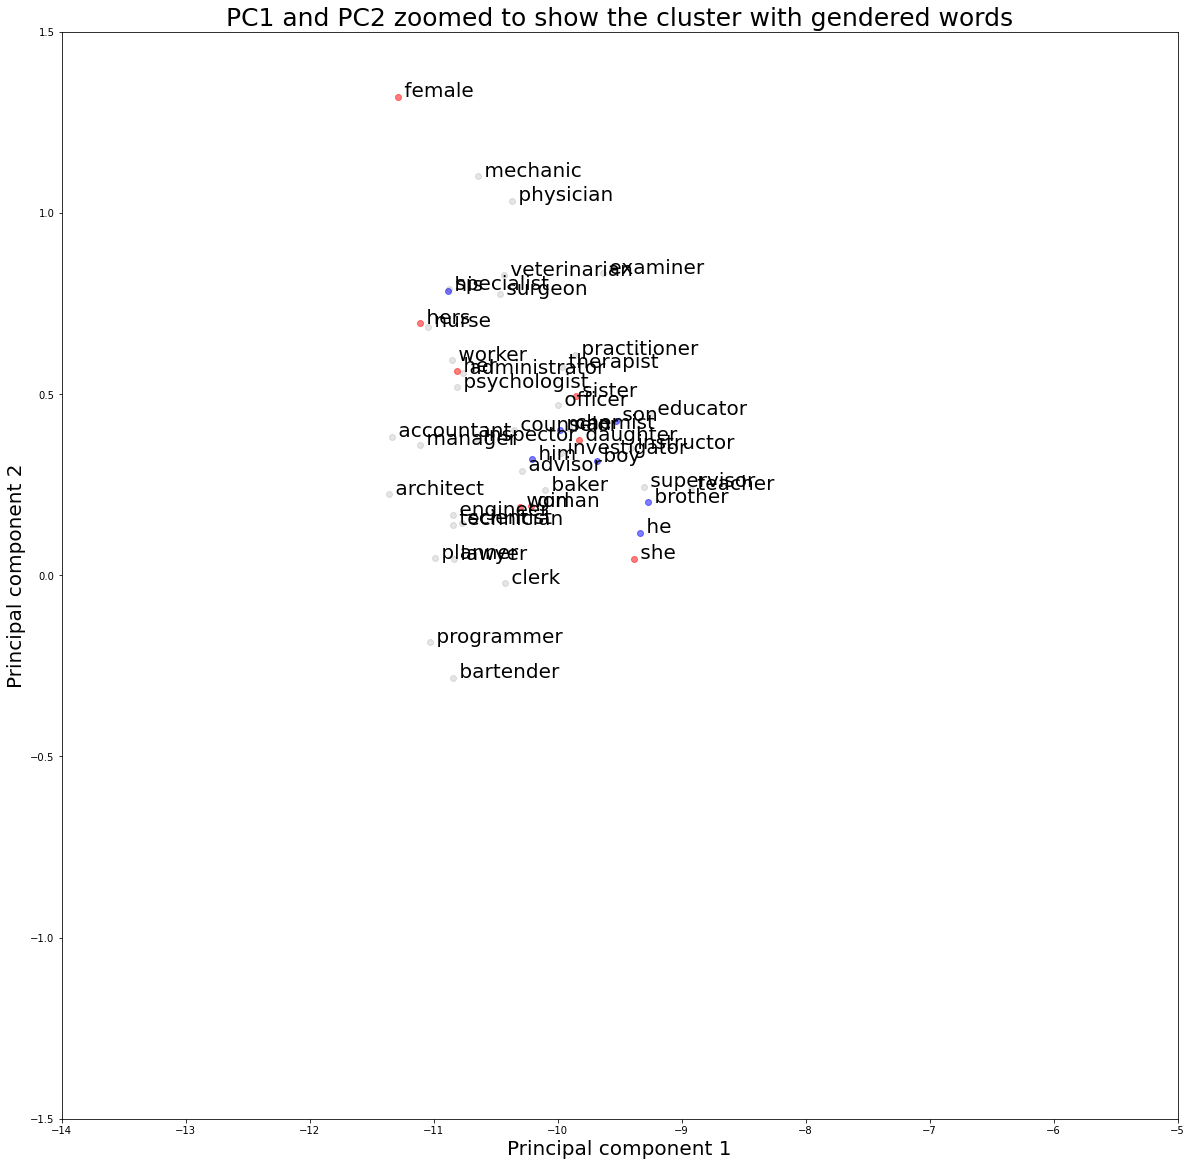

In [14]:
#plt.scatter(red_dat[:50, 0], red_dat[:50, 1], c='k') #first 50 are career words
plt.figure(figsize=(20, 20))
plt.title("PC1 and PC2 zoomed to show the cluster with gendered words", size = 25)
plt.scatter(red_dat[50:58, 0], red_dat[50:58, 1], c='r', alpha = 0.5) # female words
plt.scatter(red_dat[59:, 0], red_dat[59:, 1], c='b', alpha = 0.5) # male words
plt.scatter(red_dat[:50, 0], red_dat[:50, 1], c='k', alpha = 0.1) #first 50 are career words

for i, name in enumerate(ws):
    plt.annotate(name, (red_dat[i,0], red_dat[i,1]), size = 20)

plt.xlim(-14, -5)
plt.ylim(-1.5, 1.5)
plt.xlabel("Principal component 1", size = 20)
plt.ylabel("Principal component 2", size = 20)
plt.show()

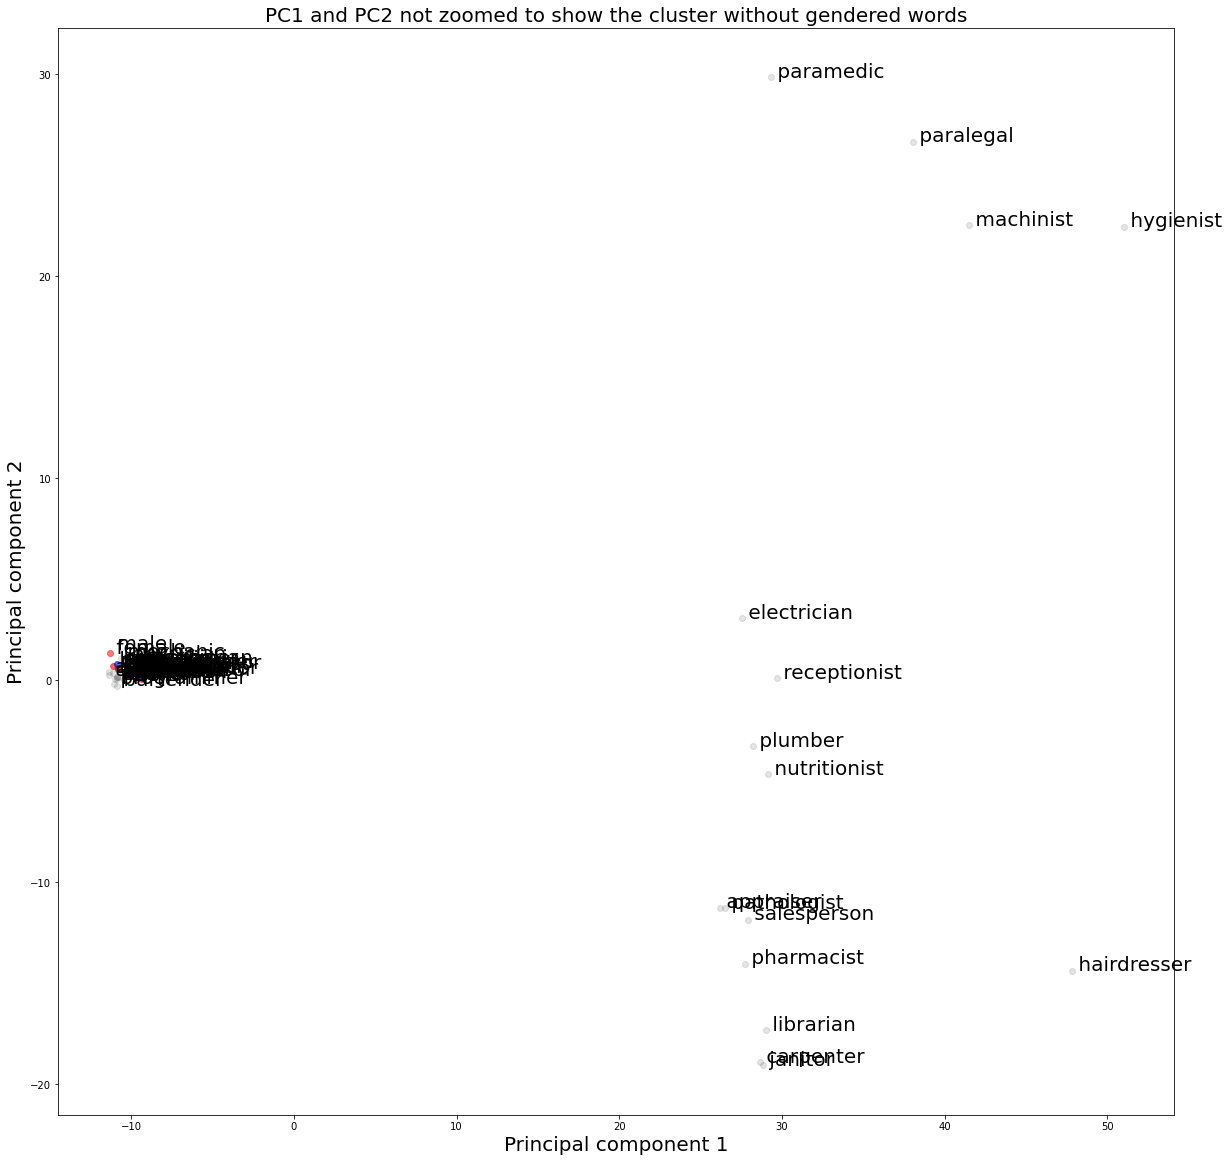

In [15]:
#plt.scatter(red_dat[:50, 0], red_dat[:50, 1], c='k') #first 50 are career words
plt.figure(figsize=(20, 20))

plt.title("PC1 and PC2 not zoomed to show the cluster without gendered words", size = 20)


plt.scatter(red_dat[50:58, 0], red_dat[50:58, 1], c='r', alpha = 0.5) # female words
plt.scatter(red_dat[59:, 0], red_dat[59:, 1], c='b', alpha = 0.5) # male words
plt.scatter(red_dat[:50, 0], red_dat[:50, 1], c='k', alpha = 0.1) #first 50 are career words

for i, name in enumerate(ws):
    plt.annotate(name, (red_dat[i,0], red_dat[i,1]), size = 20)
    
plt.xlabel("Principal component 1", size = 20)
plt.ylabel("Principal component 2", size = 20)
plt.show()

# plt.xlim(-14, -5)
# plt.ylim(-1.5, 1.5)

From the plots above, we notice that there is a cluster around gendered words, such as: mechanic, bartender, architect, baker, surgeon, accountant, supervisor.

Additionally, we see that there are some other words that are spacially far away from that cluster, meaning: paralegal, plumber, librarian, hairdresser, machinist, hygienist, pharmacist and salesperson.

It seems that our model considers the words near the gender-word cluster to be gendered-careers. And the words away from it to be non-gendered careers.

Our scope here is to 'discover' whether gender-bias or a gender-component is instrisic of a specific mode given a singular value decomposition of our matrix. 

We go about this by: creating the rank-1 matrix-reconstruction per each mode and plotting the covariances and correlation between woman-career and man-career across each mode.

If there is a mode that 'contains' bias, we expect the correlation or covariance to diverge systematically in a specific mode.  

## Singular value decomposition



In [16]:
u, s, vh = np.linalg.svd(scaled_dat, full_matrices=False)

In [17]:
u.shape # each row represents each word

(66, 66)

In [18]:
s.shape, s  # singular values 

((66,),
 array([1.5166562e+02, 6.7020981e+01, 5.9918186e+01, 5.5957623e+01,
        5.4365677e+01, 4.7179371e+01, 4.4650730e+01, 4.0084526e+01,
        3.5854889e+01, 3.5281452e+01, 2.8531898e+01, 2.8244211e+01,
        2.3241951e+01, 2.1388004e+01, 1.9079592e+01, 1.7891777e+01,
        1.5495920e+01, 1.5252658e+01, 1.3422255e+01, 1.0359640e+01,
        9.7154894e+00, 9.0867138e+00, 8.7375326e+00, 8.2000027e+00,
        7.9943213e+00, 7.4346251e+00, 7.2347746e+00, 6.8587890e+00,
        6.2028732e+00, 6.0851569e+00, 5.9021173e+00, 5.6004181e+00,
        5.5461202e+00, 5.3754878e+00, 5.1483464e+00, 4.9374685e+00,
        4.8573346e+00, 4.6973786e+00, 4.5872383e+00, 4.4211125e+00,
        4.3521490e+00, 4.1626630e+00, 4.0858936e+00, 3.9036441e+00,
        3.7793009e+00, 3.6867499e+00, 3.6011932e+00, 3.5257838e+00,
        3.3527265e+00, 3.2879279e+00, 3.2173471e+00, 3.1983557e+00,
        3.1043174e+00, 2.8944790e+00, 2.7493868e+00, 2.6387064e+00,
        2.4001439e+00, 2.2275383e+00, 2.

In [19]:
vh.shape  # 

(66, 768)

In [20]:
# ws = ' technician, accountant, supervisor, engineer,
# worker, educator, clerk, counselor, inspector, mechanic, manager, therapist, 
# administrator, salesperson, receptionist, librarian, advisor, pharmacist, janitor, psychologist,
# physician, carpenter, nurse, investigator, bartender, specialist, electrician, officer, pathologist, 
# teacher, lawyer, planner, practitioner, plumber, instructor, surgeon, veterinarian, paramedic, examiner, 
# chemist, machinist, appraiser, nutritionist, architect, hairdresser, baker, programmer, paralegal, hygienist, 
# scientist, 
# female, woman, girl, sister, she, her, hers, daughter, 
# male, man, boy, brother, he, him, his, son'

index_woman = ws.index(' woman')
index_man = ws.index(' man')
index_lawyer = ws.index(' lawyer')
index_surgeon = ws.index(' surgeon')
index_engineer = ws.index(' engineer')
index_receptionist = ws.index(' receptionist')
index_paramedic = ws.index(' paramedic')
index_programmer = ws.index(' programmer')
index_scientist = ws.index(' scientist')


In [21]:
mode_id = 10

u_vec = u[:, mode_id]
v_vec = vh[mode_id, :]

mode_mat = np.outer(u_vec, v_vec)
mode_mat.shape

(66, 768)

In [22]:
word_scores = []
for word_idx, w in enumerate(ws):
    w_vec = mode_mat[word_idx, :]
    score = np.abs(w_vec).sum()
    word_scores.append((word_idx, w, score))
    
word_scores.sort(key=lambda vs: vs[2], reverse=True) 
#word_scores

In [23]:

# gendered

cov_list_w_bartender = []
cov_list_w_surgeon = []
cov_list_w_baker = []
cov_list_w_accountant = []
cov_list_w_supervisor = []
cov_list_w_mechanic = []

cov_list_m_bartender = []
cov_list_m_surgeon = []
cov_list_m_baker = []
cov_list_m_accountant = []
cov_list_m_supervisor = []
cov_list_m_mechanic = []

## corr

corr_list_w_bartender = []
corr_list_w_surgeon = []
corr_list_w_baker = []
corr_list_w_accountant = []
corr_list_w_supervisor = []
corr_list_w_mechanic = []

corr_list_m_bartender = []
corr_list_m_surgeon = []
corr_list_m_baker = []
corr_list_m_accountant = []
corr_list_m_supervisor = []
corr_list_m_mechanic = []



# ungendered

cov_list_w_paralegal = []
cov_list_w_plumber = []
cov_list_w_librarian = []
cov_list_w_machinist = []
cov_list_w_hairdresser = []
cov_list_w_salesperson = []

cov_list_m_paralegal = []
cov_list_m_plumber = []
cov_list_m_librarian = []
cov_list_m_machinist = []
cov_list_m_hairdresser = []
cov_list_m_salesperson = []

## corr

corr_list_w_paralegal = []
corr_list_w_plumber = []
corr_list_w_librarian = []
corr_list_w_machinist = []
corr_list_w_hairdresser = []
corr_list_w_salesperson = []

corr_list_m_paralegal = []
corr_list_m_plumber = []
corr_list_m_librarian = []
corr_list_m_machinist = []
corr_list_m_hairdresser = []
corr_list_m_salesperson = []



#### cov - out of interest

cov_list_w_law = []
cov_list_w_scientist = []
cov_list_w_engineer = []
cov_list_w_programmer = []
cov_list_w_receptionist = []
cov_list_w_nurse = []



cov_list_m_law = []
cov_list_m_scientist = []
cov_list_m_engineer = []
cov_list_m_programmer = []
cov_list_m_receptionist = []
cov_list_m_nurse = []

## corr

corr_list_w_law = []
corr_list_w_scientist = []
corr_list_w_engineer = []
corr_list_w_programmer = []
corr_list_w_receptionist = []
corr_list_w_nurse = []


corr_list_m_law = []
corr_list_m_scientist = []
corr_list_m_engineer = []
corr_list_m_programmer = []
corr_list_m_receptionist = []
corr_list_m_nurse = []





for mode_id in range(0, 66):

    u_vec = u[:, mode_id]
    v_vec = vh[mode_id, :]

    mode_mat = np.outer(u_vec, v_vec)
    mode_mat.shape
    
    
    # tried out of interest 
    
    index_woman = ws.index(' woman')
    index_man = ws.index(' man')
    
    index_lawyer = ws.index(' lawyer')
    index_surgeon = ws.index(' surgeon')
    index_engineer = ws.index(' engineer')
    index_receptionist = ws.index(' receptionist')
    index_paramedic = ws.index(' paramedic')
    index_programmer = ws.index(' programmer')
    index_scientist = ws.index(' scientist')
    index_nurse = ws.index(' nurse')

    
    cov_list_w_law.append(np.cov(mode_mat[index_woman, :], mode_mat[index_lawyer, :])[0,1])
    cov_list_w_scientist.append(np.cov(mode_mat[index_woman, :], mode_mat[index_scientist, :])[0,1])
    cov_list_w_engineer.append(np.cov(mode_mat[index_woman, :], mode_mat[index_engineer, :])[0,1])
    cov_list_w_programmer.append(np.cov(mode_mat[index_woman, :], mode_mat[index_programmer, :])[0,1])
    cov_list_w_receptionist.append(np.cov(mode_mat[index_woman, :], mode_mat[index_receptionist, :])[0,1])
    cov_list_w_nurse.append(np.cov(mode_mat[index_woman, :], mode_mat[index_nurse, :])[0,1])
    
    cov_list_m_law.append(np.cov(mode_mat[index_man, :], mode_mat[index_lawyer, :])[0,1])
    cov_list_m_scientist.append(np.cov(mode_mat[index_man, :], mode_mat[index_scientist, :])[0,1])
    cov_list_m_engineer.append(np.cov(mode_mat[index_man, :], mode_mat[index_engineer, :])[0,1])
    cov_list_m_programmer.append(np.cov(mode_mat[index_man, :], mode_mat[index_programmer, :])[0,1])
    cov_list_m_receptionist.append(np.cov(mode_mat[index_man, :], mode_mat[index_receptionist, :])[0,1])
    cov_list_m_nurse.append(np.cov(mode_mat[index_man, :], mode_mat[index_nurse, :])[0,1])
    
    
    ## correlations of the words tried out of interest
    
    corr_list_w_law.append(pearsonr(mode_mat[index_woman, :], mode_mat[index_lawyer, :])[0])
    corr_list_w_scientist.append(pearsonr(mode_mat[index_woman, :], mode_mat[index_scientist, :])[0])
    corr_list_w_engineer.append(pearsonr(mode_mat[index_woman, :], mode_mat[index_engineer, :])[0])
    corr_list_w_programmer.append(pearsonr(mode_mat[index_woman, :], mode_mat[index_programmer, :])[0])
    corr_list_w_receptionist.append(pearsonr(mode_mat[index_woman, :], mode_mat[index_receptionist, :])[0])
    corr_list_w_nurse.append(pearsonr(mode_mat[index_woman, :], mode_mat[index_nurse, :])[0])
    
    corr_list_m_law.append(pearsonr(mode_mat[index_man, :], mode_mat[index_lawyer, :])[0])
    corr_list_m_scientist.append(pearsonr(mode_mat[index_man, :], mode_mat[index_scientist, :])[0])
    corr_list_m_engineer.append(pearsonr(mode_mat[index_man, :], mode_mat[index_engineer, :])[0])
    corr_list_m_programmer.append(pearsonr(mode_mat[index_man, :], mode_mat[index_programmer, :])[0])
    corr_list_m_receptionist.append(pearsonr(mode_mat[index_man, :], mode_mat[index_receptionist, :])[0])
    corr_list_m_nurse.append(pearsonr(mode_mat[index_man, :], mode_mat[index_nurse, :])[0])
    
    ################# gendered
    
    index_bartender = ws.index(' bartender')
    index_surgeon = ws.index(' surgeon')
    index_baker = ws.index(' baker')
    index_accountant = ws.index(' accountant')
    index_supervisor = ws.index(' supervisor')
    index_mechanic = ws.index(' mechanic')
    
    cov_list_w_bartender.append(np.cov(mode_mat[index_woman, :], mode_mat[index_bartender, :])[0,1])
    cov_list_w_surgeon.append(np.cov(mode_mat[index_woman, :], mode_mat[index_surgeon, :])[0,1])
    cov_list_w_baker.append(np.cov(mode_mat[index_woman, :], mode_mat[index_baker, :])[0,1])
    cov_list_w_accountant.append(np.cov(mode_mat[index_woman, :], mode_mat[index_accountant, :])[0,1])
    cov_list_w_supervisor.append(np.cov(mode_mat[index_woman, :], mode_mat[index_supervisor, :])[0,1])
    cov_list_w_mechanic.append(np.cov(mode_mat[index_woman, :], mode_mat[index_mechanic, :])[0,1])
        
    cov_list_m_bartender.append(np.cov(mode_mat[index_man, :], mode_mat[index_bartender, :])[0,1])
    cov_list_m_surgeon.append(np.cov(mode_mat[index_man, :], mode_mat[index_surgeon, :])[0,1])
    cov_list_m_baker.append(np.cov(mode_mat[index_man, :], mode_mat[index_baker, :])[0,1])
    cov_list_m_accountant.append(np.cov(mode_mat[index_man, :], mode_mat[index_accountant, :])[0,1])
    cov_list_m_supervisor.append(np.cov(mode_mat[index_man, :], mode_mat[index_supervisor, :])[0,1])
    cov_list_m_mechanic.append(np.cov(mode_mat[index_man, :], mode_mat[index_mechanic, :])[0,1])
    
    corr_list_w_bartender.append(pearsonr(mode_mat[index_woman, :], mode_mat[index_bartender, :])[0])
    corr_list_w_surgeon.append(pearsonr(mode_mat[index_woman, :], mode_mat[index_surgeon, :])[0])
    corr_list_w_baker.append(pearsonr(mode_mat[index_woman, :], mode_mat[index_baker, :])[0])
    corr_list_w_accountant.append(pearsonr(mode_mat[index_woman, :], mode_mat[index_accountant, :])[0])
    corr_list_w_supervisor.append(pearsonr(mode_mat[index_woman, :], mode_mat[index_supervisor, :])[0])
    corr_list_w_mechanic.append(pearsonr(mode_mat[index_woman, :], mode_mat[index_mechanic, :])[0])
        
    corr_list_m_bartender.append(pearsonr(mode_mat[index_man, :], mode_mat[index_bartender, :])[0])
    corr_list_m_surgeon.append(pearsonr(mode_mat[index_man, :], mode_mat[index_surgeon, :])[0])
    corr_list_m_baker.append(pearsonr(mode_mat[index_man, :], mode_mat[index_baker, :])[0])
    corr_list_m_accountant.append(pearsonr(mode_mat[index_man, :], mode_mat[index_accountant, :])[0])
    corr_list_m_supervisor.append(pearsonr(mode_mat[index_man, :], mode_mat[index_supervisor, :])[0])
    corr_list_m_mechanic.append(pearsonr(mode_mat[index_man, :], mode_mat[index_mechanic, :])[0])

    
    ################# not gendered
    
    index_paralegal = ws.index(' paralegal')
    index_plumber = ws.index(' plumber')
    index_librarian = ws.index(' librarian')
    index_machinist = ws.index(' machinist')
    index_hairdresser = ws.index(' hairdresser')
    index_salesperson = ws.index(' salesperson')  
    
    cov_list_w_paralegal.append(np.cov(mode_mat[index_man, :], mode_mat[index_paralegal, :])[0,1])
    cov_list_w_plumber.append(np.cov(mode_mat[index_man, :], mode_mat[index_plumber, :])[0,1])
    cov_list_w_librarian.append(np.cov(mode_mat[index_man, :], mode_mat[index_librarian, :])[0,1])
    cov_list_w_machinist.append(np.cov(mode_mat[index_man, :], mode_mat[index_machinist, :])[0,1])
    cov_list_w_hairdresser.append(np.cov(mode_mat[index_man, :], mode_mat[index_hairdresser, :])[0,1])
    cov_list_w_salesperson.append(np.cov(mode_mat[index_man, :], mode_mat[index_salesperson, :])[0,1])
    

    cov_list_m_paralegal.append(np.cov(mode_mat[index_man, :], mode_mat[index_paralegal, :])[0,1])
    cov_list_m_plumber.append(np.cov(mode_mat[index_man, :], mode_mat[index_plumber, :])[0,1])
    cov_list_m_librarian.append(np.cov(mode_mat[index_man, :], mode_mat[index_librarian, :])[0,1])
    cov_list_m_machinist.append(np.cov(mode_mat[index_man, :], mode_mat[index_machinist, :])[0,1])
    cov_list_m_hairdresser.append(np.cov(mode_mat[index_man, :], mode_mat[index_hairdresser, :])[0,1])
    cov_list_m_salesperson.append(np.cov(mode_mat[index_man, :], mode_mat[index_salesperson, :])[0,1])
    
    
    ## correlations of not gendered
    
    corr_list_w_paralegal.append(pearsonr(mode_mat[index_man, :], mode_mat[index_paralegal, :])[0])
    corr_list_w_plumber.append(pearsonr(mode_mat[index_man, :], mode_mat[index_plumber, :])[0])
    corr_list_w_librarian.append(pearsonr(mode_mat[index_man, :], mode_mat[index_librarian, :])[0])
    corr_list_w_machinist.append(pearsonr(mode_mat[index_man, :], mode_mat[index_machinist, :])[0])
    corr_list_w_hairdresser.append(pearsonr(mode_mat[index_man, :], mode_mat[index_hairdresser, :])[0])
    corr_list_w_salesperson.append(pearsonr(mode_mat[index_man, :], mode_mat[index_salesperson, :])[0])
    

    corr_list_m_paralegal.append(pearsonr(mode_mat[index_man, :], mode_mat[index_paralegal, :])[0])
    corr_list_m_plumber.append(pearsonr(mode_mat[index_man, :], mode_mat[index_plumber, :])[0])
    corr_list_m_librarian.append(pearsonr(mode_mat[index_man, :], mode_mat[index_librarian, :])[0])
    corr_list_m_machinist.append(pearsonr(mode_mat[index_man, :], mode_mat[index_machinist, :])[0])
    corr_list_m_hairdresser.append(pearsonr(mode_mat[index_man, :], mode_mat[index_hairdresser, :])[0])
    corr_list_m_salesperson.append(pearsonr(mode_mat[index_man, :], mode_mat[index_salesperson, :])[0])


## Covariances across every mode for woman-career and man-career pairs for careers that were considered 'gendered' through our PCA analysis

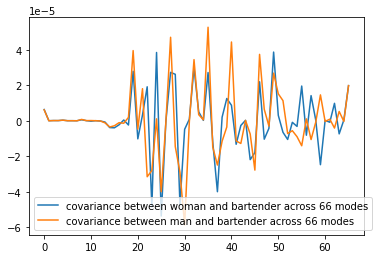

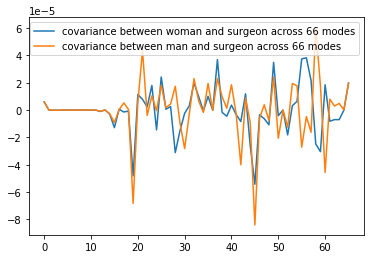

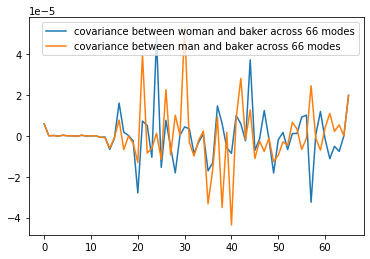

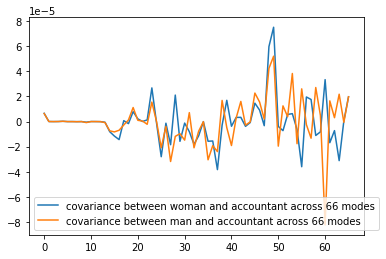

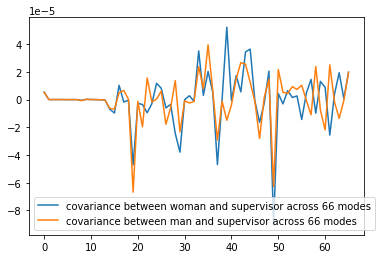

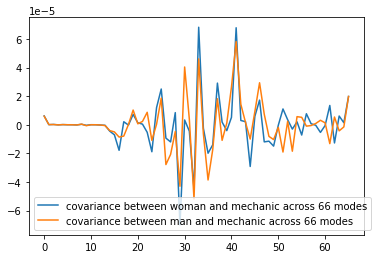

In [24]:
### GENDERED according to PCA, pc1 and pc2
    
plt.plot(list(range(0,66)), cov_list_w_bartender, label = "covariance between woman and bartender across 66 modes")
plt.plot(list(range(0,66)), cov_list_m_bartender , label = "covariance between man and bartender across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), cov_list_w_surgeon, label = "covariance between woman and surgeon across 66 modes")
plt.plot(list(range(0,66)), cov_list_m_surgeon , label = "covariance between man and surgeon across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), cov_list_w_baker, label = "covariance between woman and baker across 66 modes")
plt.plot(list(range(0,66)), cov_list_m_baker , label = "covariance between man and baker across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), cov_list_w_accountant, label = "covariance between woman and accountant across 66 modes")
plt.plot(list(range(0,66)), cov_list_m_accountant , label = "covariance between man and accountant across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), cov_list_w_supervisor, label = "covariance between woman and supervisor across 66 modes")
plt.plot(list(range(0,66)), cov_list_m_supervisor , label = "covariance between man and supervisor across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), cov_list_w_mechanic, label = "covariance between woman and mechanic across 66 modes")
plt.plot(list(range(0,66)), cov_list_m_mechanic , label = "covariance between man and mechanic across 66 modes")
plt.legend()
plt.show()

## Correlations across every mode for woman-career and man-career pairs for careers that were considered 'gendered' through our PCA analysis

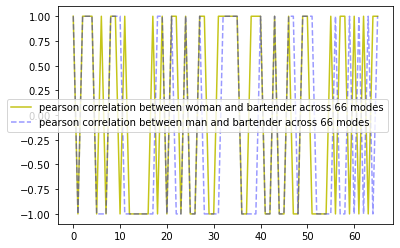

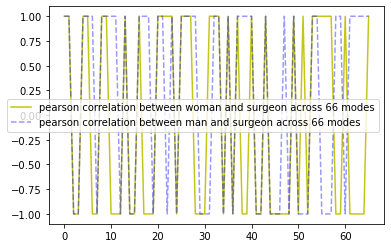

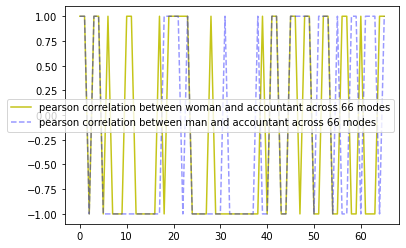

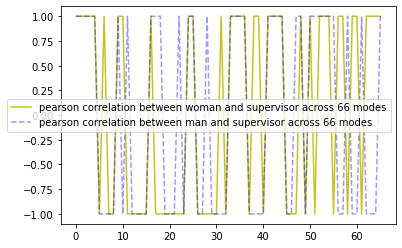

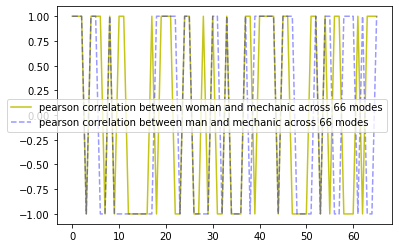

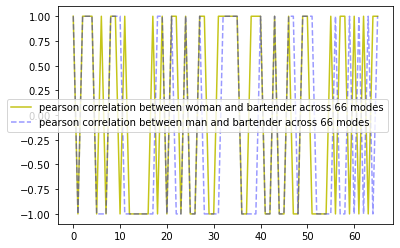

In [25]:

plt.plot(list(range(0,66)), corr_list_w_bartender, 'y', alpha = 0.9, label = "pearson correlation between woman and bartender across 66 modes")
plt.plot(list(range(0,66)), corr_list_m_bartender , 'b--', alpha = 0.4,   label = "pearson correlation between man and bartender across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), corr_list_w_surgeon, 'y', alpha = 0.9,label = "pearson correlation between woman and surgeon across 66 modes")
plt.plot(list(range(0,66)), corr_list_m_surgeon , 'b--', alpha = 0.4, label = "pearson correlation between man and surgeon across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), corr_list_w_accountant,'y',alpha = 0.9, label = "pearson correlation between woman and accountant across 66 modes")
plt.plot(list(range(0,66)), corr_list_m_accountant , 'b--', alpha = 0.4, label = "pearson correlation between man and accountant across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), corr_list_w_supervisor, 'y',alpha = 0.9,label = "pearson correlation between woman and supervisor across 66 modes")
plt.plot(list(range(0,66)), corr_list_m_supervisor , 'b--', alpha = 0.4, label = "pearson correlation between man and supervisor across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), corr_list_w_mechanic,'y',alpha = 0.9, label = "pearson correlation between woman and mechanic across 66 modes")
plt.plot(list(range(0,66)), corr_list_m_mechanic ,'b--', alpha = 0.4,  label = "pearson correlation between man and mechanic across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), corr_list_w_bartender, 'y',alpha = 0.9,label = "pearson correlation between woman and bartender across 66 modes")
plt.plot(list(range(0,66)), corr_list_m_bartender , 'b--', alpha = 0.4,label = "pearson correlation between man and bartender across 66 modes")
plt.legend()
plt.show()


## Covariances across every mode for woman-career and man-career pairs for careers that were considered 'not gendered' through our PCA analysis

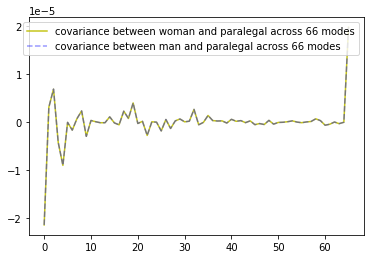

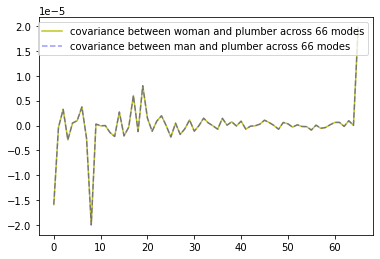

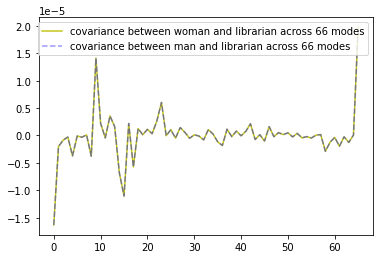

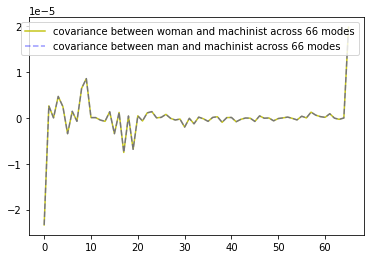

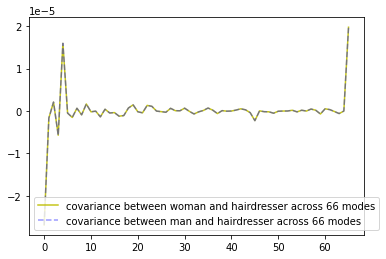

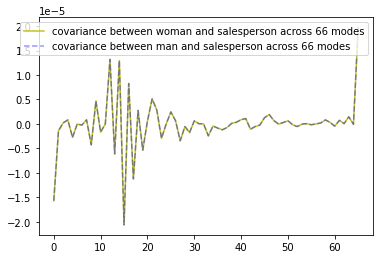

In [26]:
### NOT GENDERED according to PCA, pc1 and pc2
    
plt.plot(list(range(0,66)), cov_list_w_paralegal, 'y', alpha = 0.9, label = "covariance between woman and paralegal across 66 modes")
plt.plot(list(range(0,66)), cov_list_m_paralegal , 'b--', alpha = 0.4,   label = "covariance between man and paralegal across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), cov_list_w_plumber, 'y', alpha = 0.9, label = "covariance between woman and plumber across 66 modes")
plt.plot(list(range(0,66)), cov_list_m_plumber , 'b--', alpha = 0.4, label = "covariance between man and plumber across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), cov_list_w_librarian,'y', alpha = 0.9,  label = "covariance between woman and librarian across 66 modes")
plt.plot(list(range(0,66)), cov_list_m_librarian , 'b--', alpha = 0.4, label = "covariance between man and librarian across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), cov_list_w_machinist, 'y', alpha = 0.9, label = "covariance between woman and machinist across 66 modes")
plt.plot(list(range(0,66)), cov_list_m_machinist ,  'b--', alpha = 0.4,label = "covariance between man and machinist across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), cov_list_w_hairdresser,'y', alpha = 0.9,  label = "covariance between woman and hairdresser across 66 modes")
plt.plot(list(range(0,66)), cov_list_m_hairdresser , 'b--', alpha = 0.4, label = "covariance between man and hairdresser across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), cov_list_w_salesperson, 'y', alpha = 0.9, label = "covariance between woman and salesperson across 66 modes")
plt.plot(list(range(0,66)), cov_list_m_salesperson ,  'b--', alpha = 0.4,label = "covariance between man and salesperson across 66 modes")
plt.legend()
plt.show()


## Correlations across every mode for woman-career and man-career pairs for careers that were considered 'not gendered' through our PCA analysis

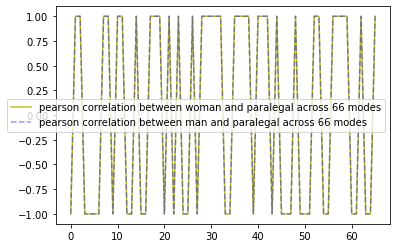

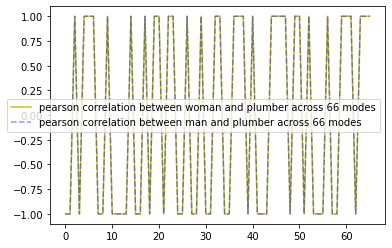

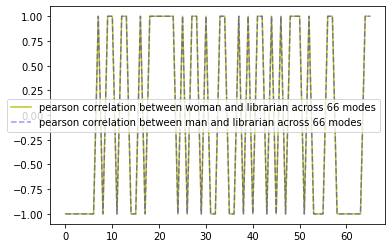

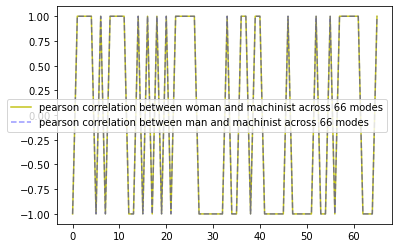

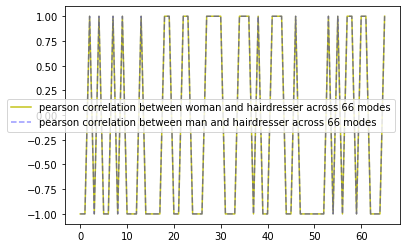

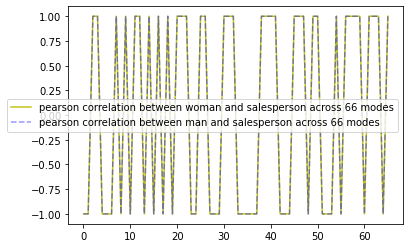

In [27]:
### CORRELATION NOT GENDERED according to PCA, pc1 and pc2
    
plt.plot(list(range(0,66)), corr_list_w_paralegal, 'y', alpha = 0.9, label = "pearson correlation between woman and paralegal across 66 modes")
plt.plot(list(range(0,66)), corr_list_m_paralegal , 'b--', alpha = 0.4,   label = "pearson correlation between man and paralegal across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), corr_list_w_plumber, 'y', alpha = 0.9,label = "pearson correlation between woman and plumber across 66 modes")
plt.plot(list(range(0,66)), corr_list_m_plumber , 'b--', alpha = 0.4, label = "pearson correlation between man and plumber across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), corr_list_w_librarian,'y',alpha = 0.9, label = "pearson correlation between woman and librarian across 66 modes")
plt.plot(list(range(0,66)), corr_list_m_librarian , 'b--', alpha = 0.4, label = "pearson correlation between man and librarian across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), corr_list_w_machinist, 'y',alpha = 0.9,label = "pearson correlation between woman and machinist across 66 modes")
plt.plot(list(range(0,66)), corr_list_m_machinist , 'b--', alpha = 0.4, label = "pearson correlation between man and machinist across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), corr_list_w_hairdresser,'y',alpha = 0.9, label = "pearson correlation between woman and hairdresser across 66 modes")
plt.plot(list(range(0,66)), corr_list_m_hairdresser ,'b--', alpha = 0.4,  label = "pearson correlation between man and hairdresser across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), corr_list_w_salesperson, 'y',alpha = 0.9,label = "pearson correlation between woman and salesperson across 66 modes")
plt.plot(list(range(0,66)), corr_list_m_salesperson , 'b--', alpha = 0.4,label = "pearson correlation between man and salesperson across 66 modes")
plt.legend()
plt.show()



## Covariances across every mode for woman-career and man-career pairs for careers tried out of interest

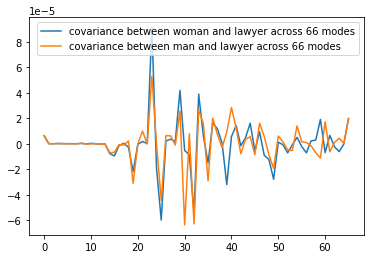

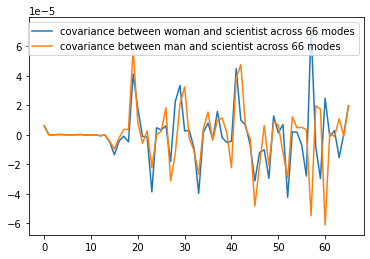

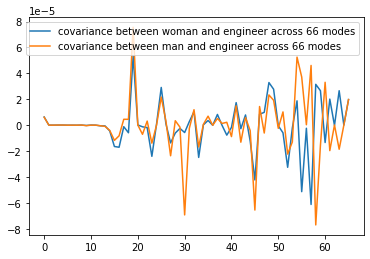

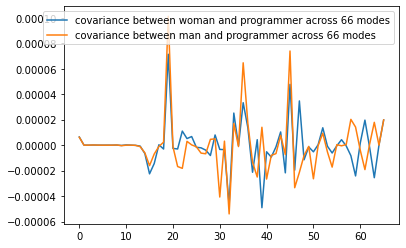

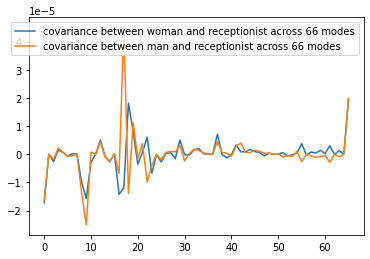

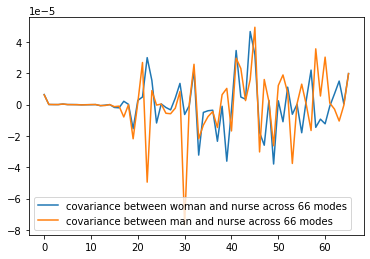

In [28]:
### OUT OF INTEREST

plt.plot(list(range(0,66)), cov_list_w_law, label = "covariance between woman and lawyer across 66 modes")
plt.plot(list(range(0,66)), cov_list_m_law , label = "covariance between man and lawyer across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), cov_list_w_scientist, label = "covariance between woman and scientist across 66 modes")
plt.plot(list(range(0,66)), cov_list_m_scientist , label = "covariance between man and scientist across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), cov_list_w_engineer, label = "covariance between woman and engineer across 66 modes")
plt.plot(list(range(0,66)), cov_list_m_engineer , label = "covariance between man and engineer across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), cov_list_w_programmer, label = "covariance between woman and programmer across 66 modes")
plt.plot(list(range(0,66)), cov_list_m_programmer , label = "covariance between man and programmer across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), cov_list_w_receptionist, label = "covariance between woman and receptionist across 66 modes")
plt.plot(list(range(0,66)), cov_list_m_receptionist , label = "covariance between man and receptionist across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), cov_list_w_nurse, label = "covariance between woman and nurse across 66 modes")
plt.plot(list(range(0,66)), cov_list_m_nurse , label = "covariance between man and nurse across 66 modes")
plt.legend()
plt.show()

## Correlations across every mode for woman-career and man-career pairs for careers tried out of interest

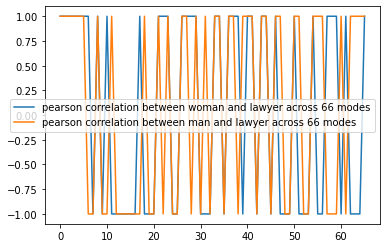

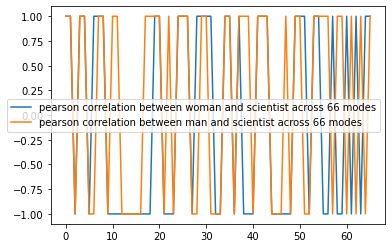

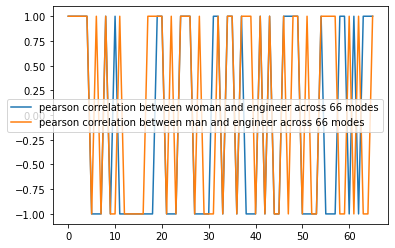

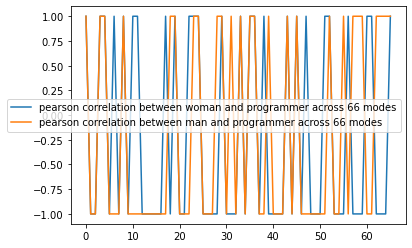

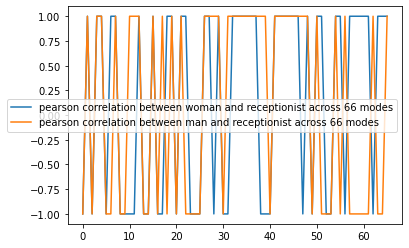

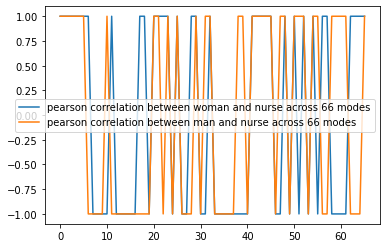

In [29]:
plt.plot(list(range(0,66)), corr_list_w_law, label = "pearson correlation between woman and lawyer across 66 modes")
plt.plot(list(range(0,66)), corr_list_m_law , label = "pearson correlation between man and lawyer across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), corr_list_w_scientist, label = "pearson correlation between woman and scientist across 66 modes")
plt.plot(list(range(0,66)), corr_list_m_scientist , label = "pearson correlation between man and scientist across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), corr_list_w_engineer, label = "pearson correlation between woman and engineer across 66 modes")
plt.plot(list(range(0,66)), corr_list_m_engineer , label = "pearson correlation between man and engineer across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), corr_list_w_programmer, label = "pearson correlation between woman and programmer across 66 modes")
plt.plot(list(range(0,66)), corr_list_m_programmer , label = "pearson correlation between man and programmer across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), corr_list_w_receptionist, label = "pearson correlation between woman and receptionist across 66 modes")
plt.plot(list(range(0,66)), corr_list_m_receptionist , label = "pearson correlation between man and receptionist across 66 modes")
plt.legend()
plt.show()

plt.plot(list(range(0,66)), corr_list_w_nurse, label = "pearson correlation between woman and nurse across 66 modes")
plt.plot(list(range(0,66)), corr_list_m_nurse , label = "pearson correlation between man and nurse across 66 modes")
plt.legend()
plt.show()


## Result - comments

We cannot notably see through the eye and these graphs a noticeable difference in a specific mode.

Given this, we cannot say whether gender bias is 'contained' is a specific mode given a singular value decomposition performed on a matrix of word vectors.

Nonetheless, we can affirm that this model 'contains bias' in a specif subset of words, i.e. the words clustered around the gendered-words in the PCA graphs plotted above. This can be reflected also by how the correlations and covariances of these words paired with man or woman vastly differ across our 66 modes. Whereas, the correlation and covariance pairs are perfectly overlapping across each mode of the 66 for the words away from the aforementioned 'gendered' cluster.

This leads to the conclusion that our model, although might not have a specific gender-bias subspace in a specific mode, has bias on a specific sub-set of words. Why does our model find bias in this specific cluster of words? This is an interesting question that we would have liked to explore further. However, this goes beyond the scope of this project, and in interest of time, we leave this for later research to explore.





# ==============================================================




# Cosine distance

Next, we try to see if these bias-carrying words have a greater distance for man compared to woman or vice versa. Meaning, if the distance of woman to surgeon is bigger than the distance of man to surgeon, we can infer that our model associates a woman less to the role of a surgeone compared to how it associates a man to a surgeon. Will the resulting distances mirror what we have found out from the PCA clusters seen above?

Each of our vectors spans across 768 latent spaces, meaning that it is impractical to plot these vectors and look at their distance, being that this would be above a 2-dimensions graph. 

Given this, we refer to another method for distance, i.e. the cosine distance. The cosine distance between two 1-dimensional arrays u and v is defined as:

$$ 1 - \frac{ u \cdot v} {||u ||_2 ||v||_2}$$



In [30]:
from scipy.spatial import distance


In [31]:
gendered_jobs = [' mechanic', ' bartender', ' baker', ' surgeon', ' accountant', ' supervisor'  ]
not_gendered_jobs = [' paralegal', ' librarian', ' hairdresser', ' machinist', ' hygienist', ' pharmacist', ' salesperson'  ]
other_jobs = [' lawyer', ' surgeon', ' engineer', ' receptionist', ' programmer', ' scientist', ' nurse'  ]

In [32]:
def distances_biases(job_name):
    #input is a string

    v_woman = get_word_vec(' woman')
    v_man = get_word_vec(' man')
    v_man_array = v_man.detach().numpy()
    v_woman_array = v_woman.detach().numpy()

    v_job = get_word_vec(job_name).detach().numpy()

    woman_job = distance.cosine(v_job, v_woman_array)
    man_job = distance.cosine(v_job, v_man_array)
    print(f" Cosine distance of woman to {job_name} : {woman_job} ")
    print(f" Cosine distance of man to {job_name} : {man_job}")
    if woman_job> man_job: 
        times = np.round(woman_job/man_job, 1)
        print(f"The distance of woman to {job_name} is higher compared to man to {job_name}: our model associates a man to {job_name} {times} times more than how it associates a woman to this role.")
    
    if woman_job< man_job: 
        times = np.round(man_job/woman_job,1)
        print(f"The distance of woman to {job_name} is smaller compared to man to {job_name}: our model associates a woman to {job_name} {times } times more than how it associates a woman to this role.")

    print("=========================================")

In [33]:
for i in gendered_jobs:
    distances_biases(i)

 Cosine distance of woman to  mechanic : 7.12275505065918e-05 
 Cosine distance of man to  mechanic : 0.0001227855682373047
The distance of woman to  mechanic is smaller compared to man to  mechanic: our model associates a woman to  mechanic 1.7 times more than how it associates a woman to this role.
 Cosine distance of woman to  bartender : 0.0001609325408935547 
 Cosine distance of man to  bartender : 0.0003598332405090332
The distance of woman to  bartender is smaller compared to man to  bartender: our model associates a woman to  bartender 2.2 times more than how it associates a woman to this role.
 Cosine distance of woman to  baker : 0.00011068582534790039 
 Cosine distance of man to  baker : 4.1961669921875e-05
The distance of woman to  baker is higher compared to man to  baker: our model associates a man to  baker 2.6 times more than how it associates a woman to this role.
 Cosine distance of woman to  surgeon : 5.239248275756836e-05 
 Cosine distance of man to  surgeon : 6.777

In [34]:
for i in not_gendered_jobs:
    distances_biases(i)

 Cosine distance of woman to  paralegal : 0.020685672760009766 
 Cosine distance of man to  paralegal : 0.0193212628364563
The distance of woman to  paralegal is higher compared to man to  paralegal: our model associates a man to  paralegal 1.1 times more than how it associates a woman to this role.
 Cosine distance of woman to  librarian : 0.0035161972045898438 
 Cosine distance of man to  librarian : 0.0029764175415039062
The distance of woman to  librarian is higher compared to man to  librarian: our model associates a man to  librarian 1.2 times more than how it associates a woman to this role.
 Cosine distance of woman to  hairdresser : 0.02752286195755005 
 Cosine distance of man to  hairdresser : 0.02642613649368286
The distance of woman to  hairdresser is higher compared to man to  hairdresser: our model associates a man to  hairdresser 1.0 times more than how it associates a woman to this role.
 Cosine distance of woman to  machinist : 0.04405331611633301 
 Cosine distance of 

In [35]:
for i in other_jobs:
    distances_biases(i)

 Cosine distance of woman to  lawyer : 0.00011324882507324219 
 Cosine distance of man to  lawyer : 0.00010186433792114258
The distance of woman to  lawyer is higher compared to man to  lawyer: our model associates a man to  lawyer 1.1 times more than how it associates a woman to this role.
 Cosine distance of woman to  surgeon : 5.239248275756836e-05 
 Cosine distance of man to  surgeon : 6.777048110961914e-05
The distance of woman to  surgeon is smaller compared to man to  surgeon: our model associates a woman to  surgeon 1.3 times more than how it associates a woman to this role.
 Cosine distance of woman to  engineer : 5.900859832763672e-05 
 Cosine distance of man to  engineer : 0.00011807680130004883
The distance of woman to  engineer is smaller compared to man to  engineer: our model associates a woman to  engineer 2.0 times more than how it associates a woman to this role.
 Cosine distance of woman to  receptionist : 0.009074211120605469 
 Cosine distance of man to  receptionis